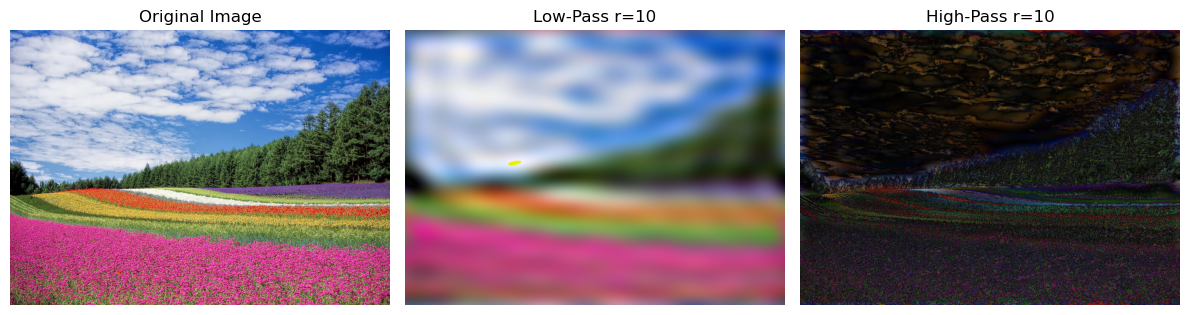

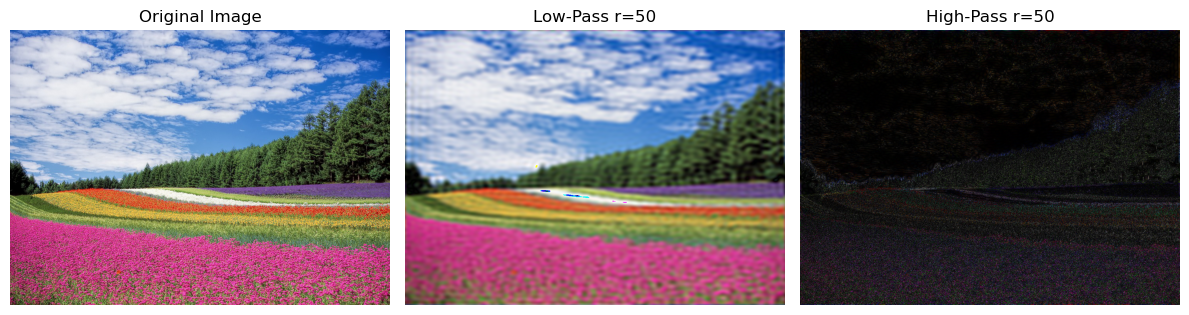

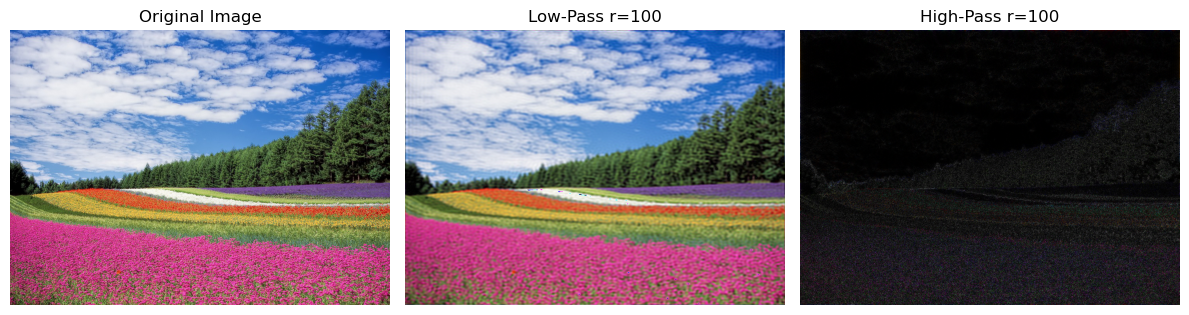

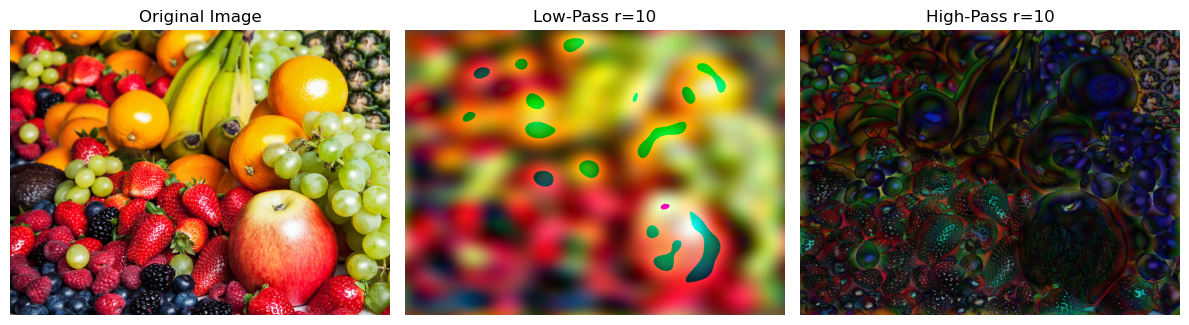

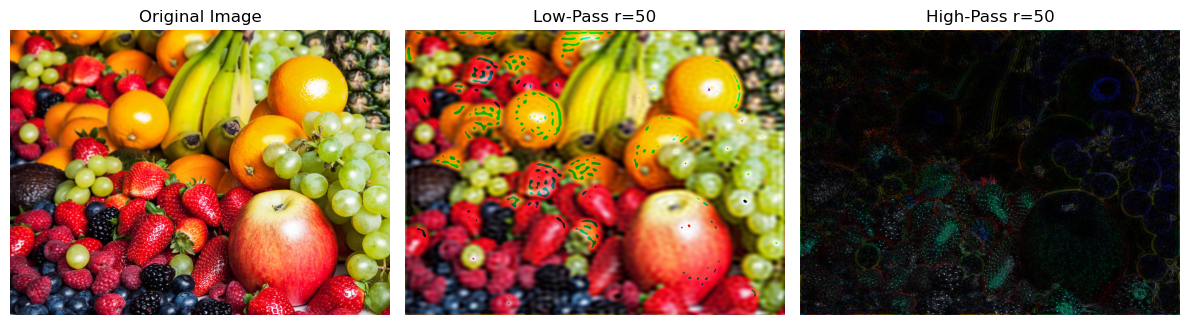

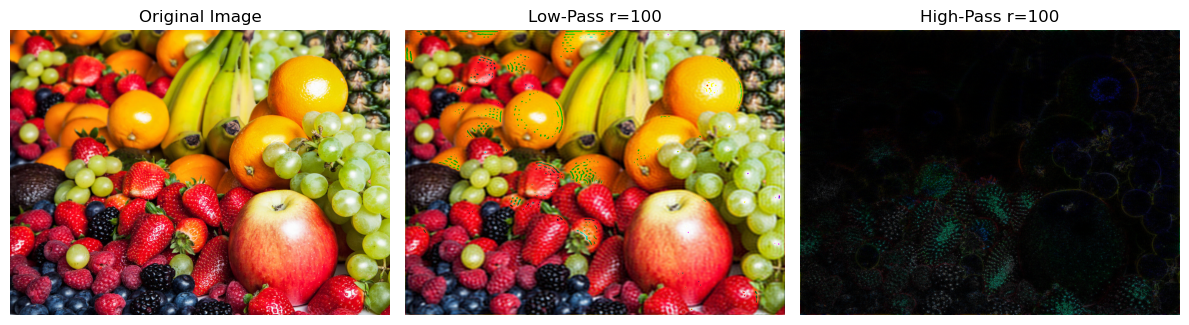

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

def notch_filter_channel(channel, filter_type, r):
    # Compute the 2D FFT
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)

    # Generate the filter
    rows, cols = channel.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    x, y = np.meshgrid(x, y)
    D = np.sqrt(x**2 + y**2)

    if filter_type == "low-pass":
        mask = np.where(D > r, 0, 1).astype(np.uint8)
    elif filter_type == "high-pass":
        mask = np.where(D <= r, 0, 1).astype(np.uint8)

    # Apply the filter
    fshift = fshift * mask
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)

    return np.uint8(img_back)

def notch_filter(image, filter_type, radius):
    # Split channels
    b, g, r_channel = cv2.split(image)
    
    # Apply filter to each channel
    b_filtered = notch_filter_channel(b, filter_type, radius)
    g_filtered = notch_filter_channel(g, filter_type, radius)
    r_filtered = notch_filter_channel(r_channel, filter_type, radius)
    
    # Merge channels
    return cv2.merge([b_filtered, g_filtered, r_filtered])

# Create OUTPUT directory if it doesn't exist
output_dir = './OUTPUT'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

images = ["../original_images/flower1.jpg", "../original_images/fruit.jpg"]
radii = [10, 50, 100]

for img_path in images:
    image = cv2.imread(img_path)
    img_name = os.path.basename(img_path).split('.')[0]
    
    for r in radii:
        low_pass_img = notch_filter(image, "low-pass", r)
        high_pass_img = notch_filter(image, "high-pass", r)

        # Display using matplotlib
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax[0].set_title('Original Image')
        ax[1].imshow(cv2.cvtColor(low_pass_img, cv2.COLOR_BGR2RGB))
        ax[1].set_title(f'Low-Pass r={r}')
        ax[2].imshow(cv2.cvtColor(high_pass_img, cv2.COLOR_BGR2RGB))
        ax[2].set_title(f'High-Pass r={r}')
        for a in ax:
            a.axis('off')
        plt.tight_layout()
        plt.show()

        # Save images to OUTPUT directory
        cv2.imwrite(os.path.join(output_dir, f"{img_name}_low_pass_r{r}.jpg"), low_pass_img)
        cv2.imwrite(os.path.join(output_dir, f"{img_name}_high_pass_r{r}.jpg"), high_pass_img)
